In [1]:
using Revise
includet("../scripts/single_influx.jl")

Precompiling packages...
  33502.0 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 38 seconds. 528 already precompiled.


In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Doing Kabirs setup

# Testing

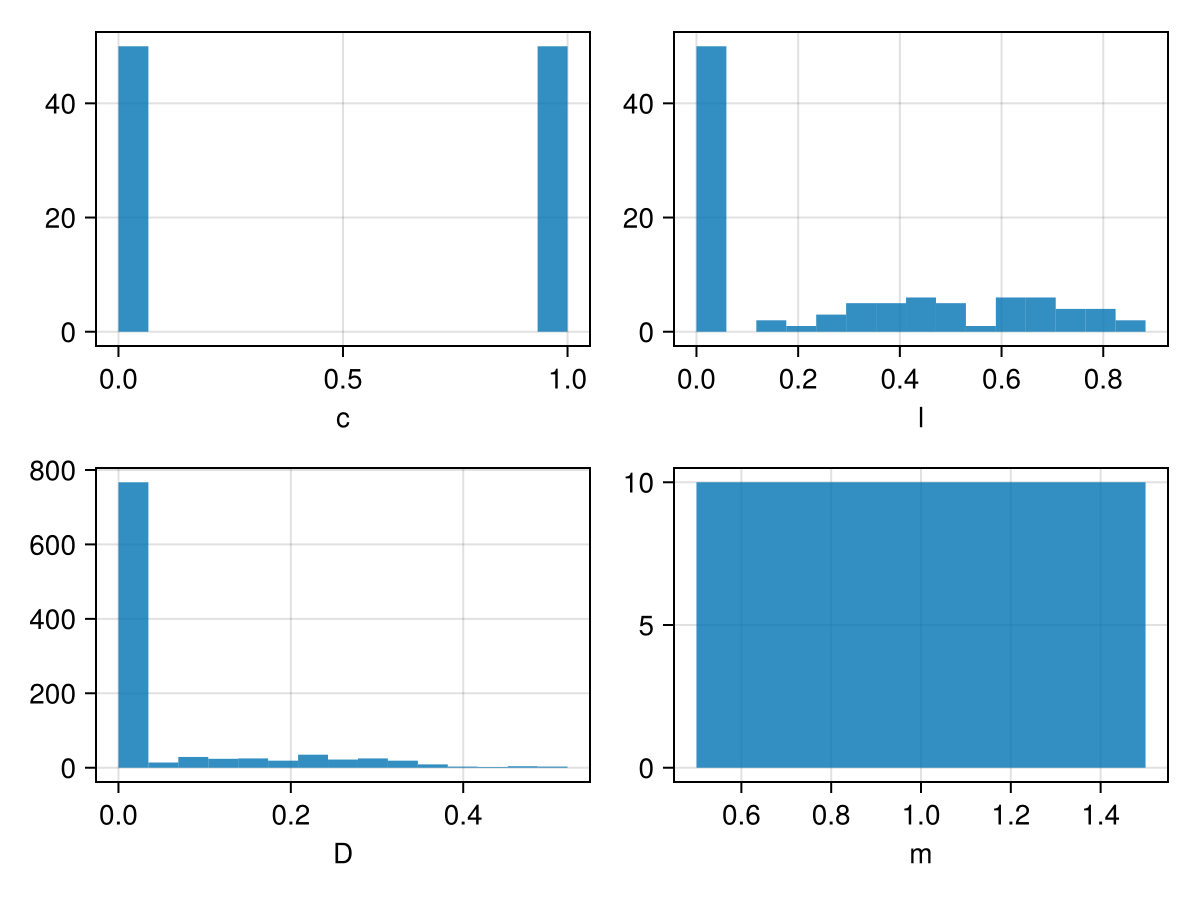

In [189]:
rsg = get_rsg_unimodalc(10;
    K=2,
    # linflux=1.
)

ps = rsg()

f = Figure()
ax1 = Axis(f[1,1]; xlabel="c")
hist!(ax1, ps.c[:])
ax2 = Axis(f[1,2]; xlabel="l")
hist!(ax2, ps.l[:])
ax3 = Axis(f[2,1]; xlabel="D")
hist!(ax3, ps.D[:])
ax4 = Axis(f[2,2]; xlabel="m")
hist!(ax4, ps.m[:])

f
# nothing

In [190]:
rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

Dict{Int64, Int64} with 2 entries:
  1   => 97
  101 => 3

In [208]:
rsg = JansSampler3(10, 10;
    m=1.,
    K=100.,
    num_influx_resources=1,
    
    prob_eating=0.1,
    num_byproducts=4,
    # l=Beta(0.5, 0.5),
    l=0.,
    c=1.,
    
    prob_eating_influx=1.,
    # linflux=1.,
    linflux=Beta(10.,0.01),
    # linflux=Beta(0.5,0.5),
    cinflux=1.,
)

ps = rsg()

f = Figure()
ax1 = Axis(f[1,1]; xlabel="c")
hist!(ax1, ps.c[:])
ax2 = Axis(f[1,2]; xlabel="l")
hist!(ax2, ps.l[:])
ax3 = Axis(f[2,1]; xlabel="D")
hist!(ax3, ps.D[:])
ax4 = Axis(f[2,2]; xlabel="m")
hist!(ax4, ps.m[:])

f;

In [210]:
rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


Dict{Int64, Int64} with 5 entries:
  22    => 14
  2     => 64
  -1004 => 1
  1     => 19
  101   => 2

# Running a single system

In [56]:
ps = rsg();
# ps = ms();

## No space solver

In [57]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=nothing,
);
maximum(abs, sss.resid)

  9.718093 seconds (13.25 M allocations: 883.607 MiB, 9.12% gc time, 99.28% compilation time)


5.204931152131454e-15

  3.042129 seconds (3.00 M allocations: 205.264 MiB, 3.35% gc time, 99.89% compilation time)


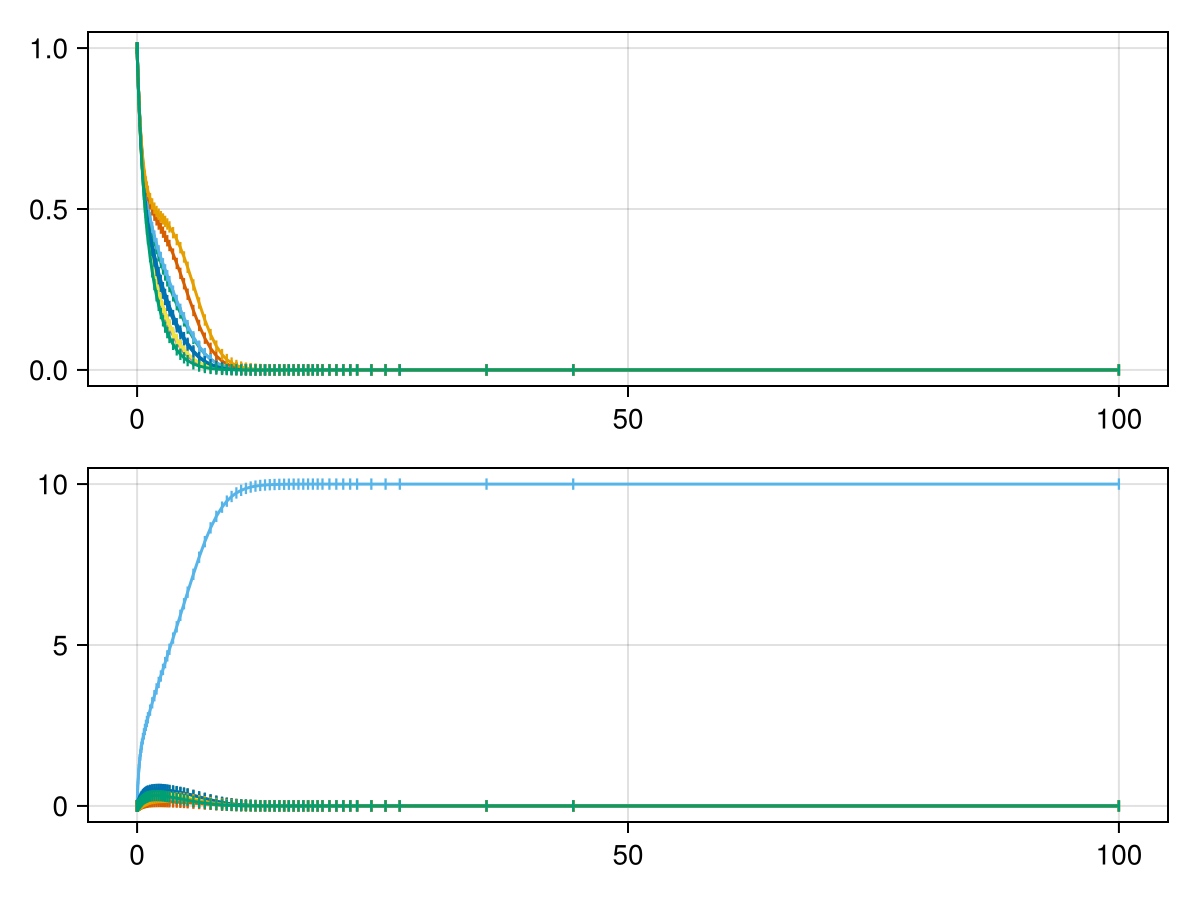

In [58]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 100);
# p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=make_timer_callback(1.)
)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

In [59]:
diagram_sfss_v3(ps, s.u[end];
    strain_threshold=1e-3,
    colorscale=identity,
)

"No strains are above the threshold and so cannot build a diagram"

## Spatial stuff

In [8]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 7.72412788068188e-16


### Linear stability

In [9]:
ks = LinRange(0., 50., 10000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-0.0001574065696420509

In [10]:
xx = LinstabScanTester2(ps, 50., 1000)
xx(ps, nssol)

(1, -0.08450047161454283, -0.0001574065696420509, false)

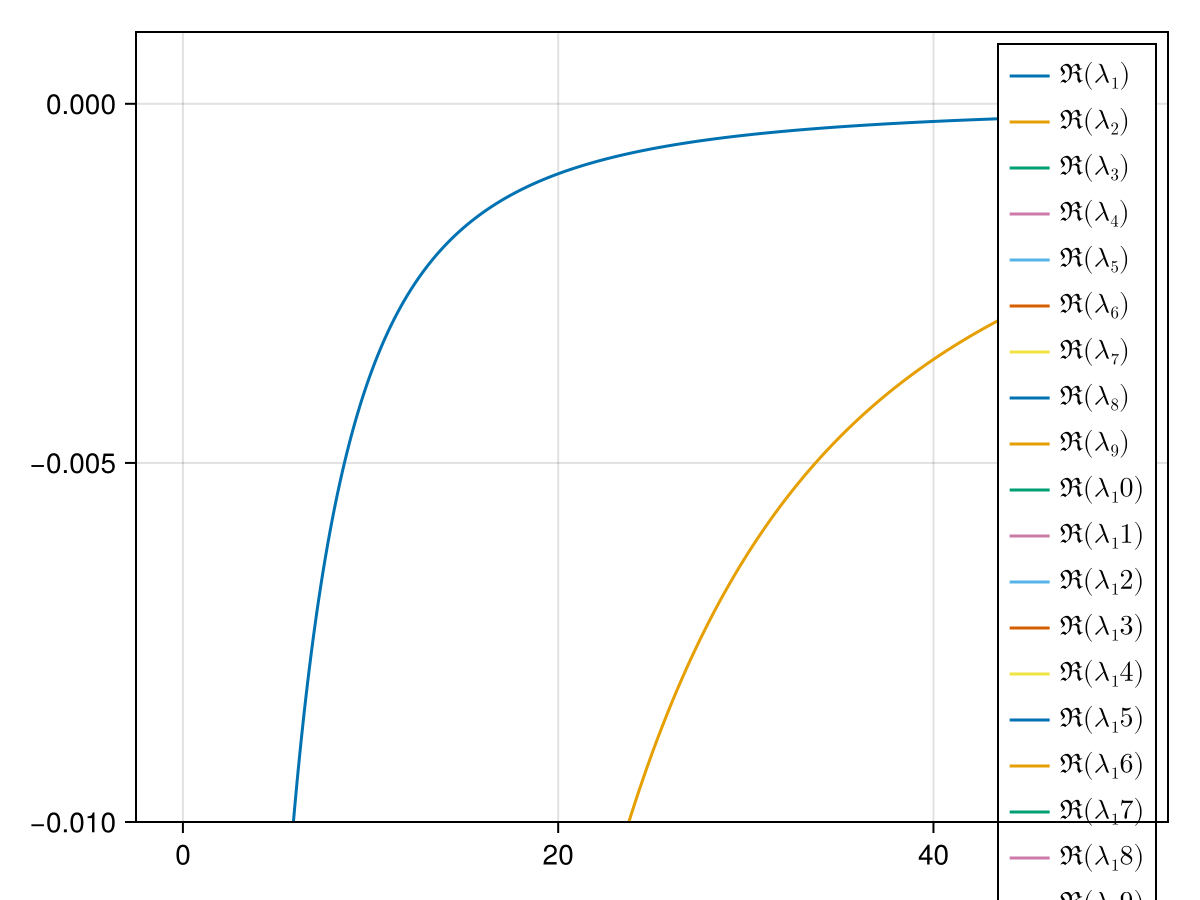

In [11]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


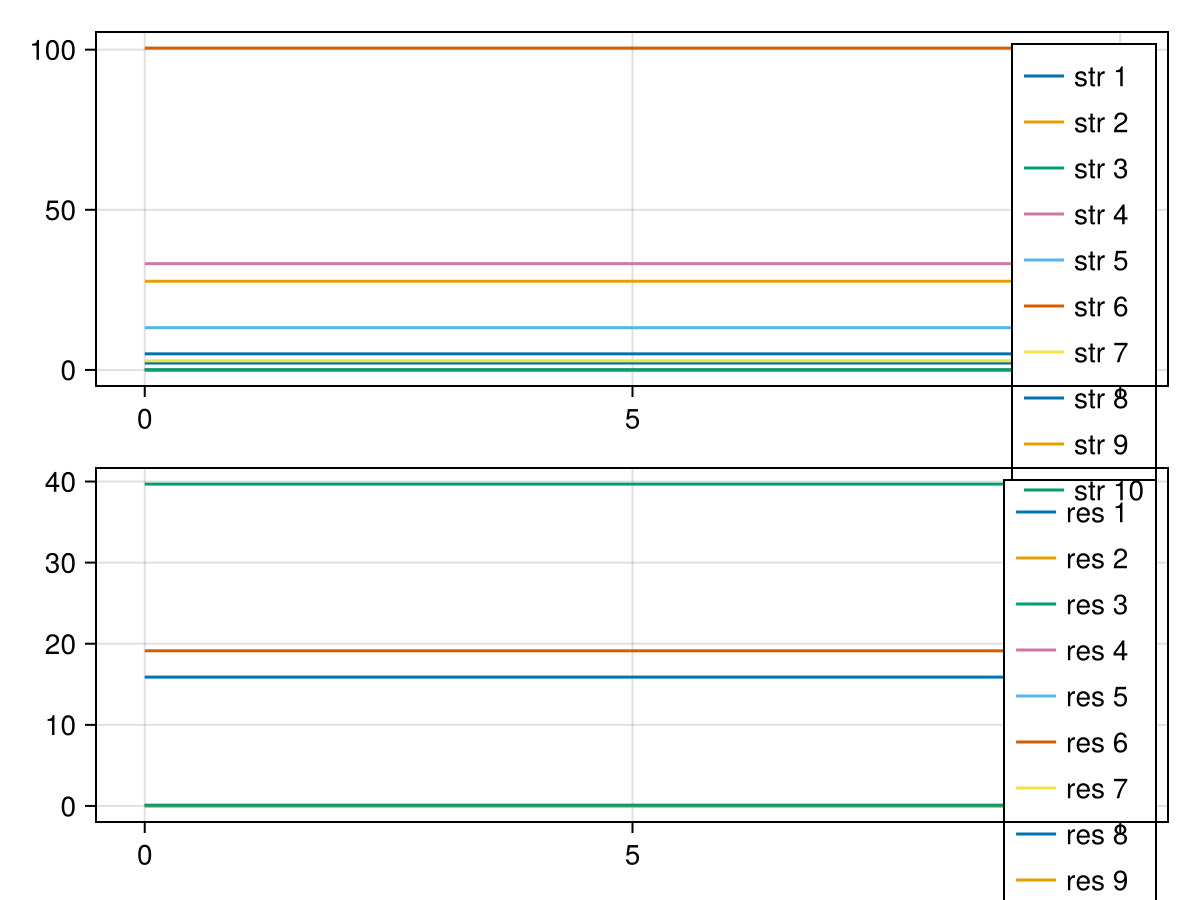

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

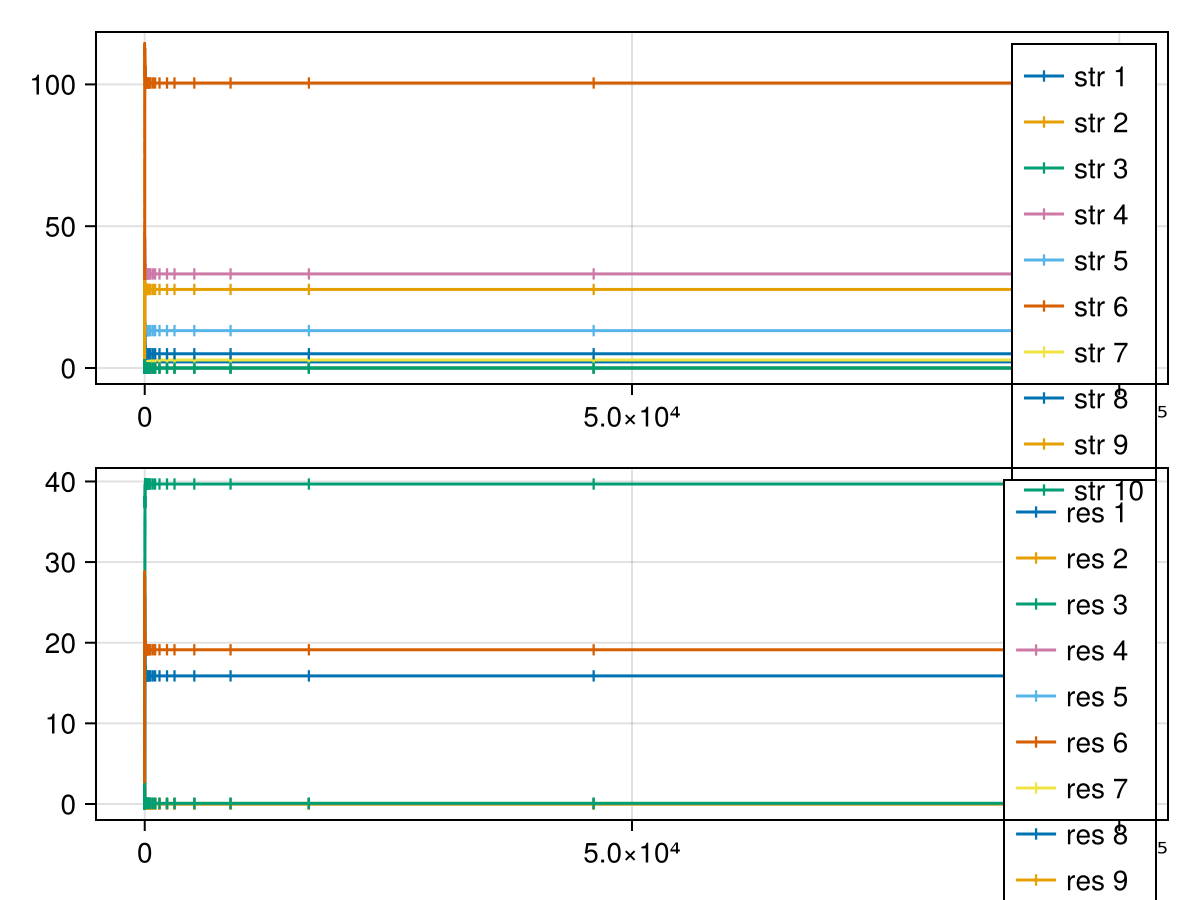

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()